In [20]:
import layoutparser as lp
import cv2
import fitz
from PIL import Image


In [2]:
pdf_path = "data/NAB/Berichte_NAB 10-025_Kurzarbeitsprogram Geothermiebohrung Schlattingen.PDF"
with fitz.Document(pdf_path) as doc:
    page = doc.load_page(2)
    pixmap = page.get_pixmap()
    image = Image.frombytes("RGB", [pixmap.width, pixmap.height], pixmap.samples)
    image.show() 

In [22]:
image = cv2.imread("data/NAB/Berichte_NAB 10-025_Kurzarbeitsprogram Geothermiebohrung Schlattingen/1738573781993-dd7bddee-9b9c-48fb-9564-a697e39665ab_7.jpg")
image = image[..., ::-1] 

In [23]:
color_map = {
    'text':   'red',
    'title':  'blue',
    'list':   'green',
    'table':  'purple',
    'figure': 'pink',
}

In [24]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [26]:
layout = model.detect(image)

In [27]:
layout_predicted = model.detect(image)

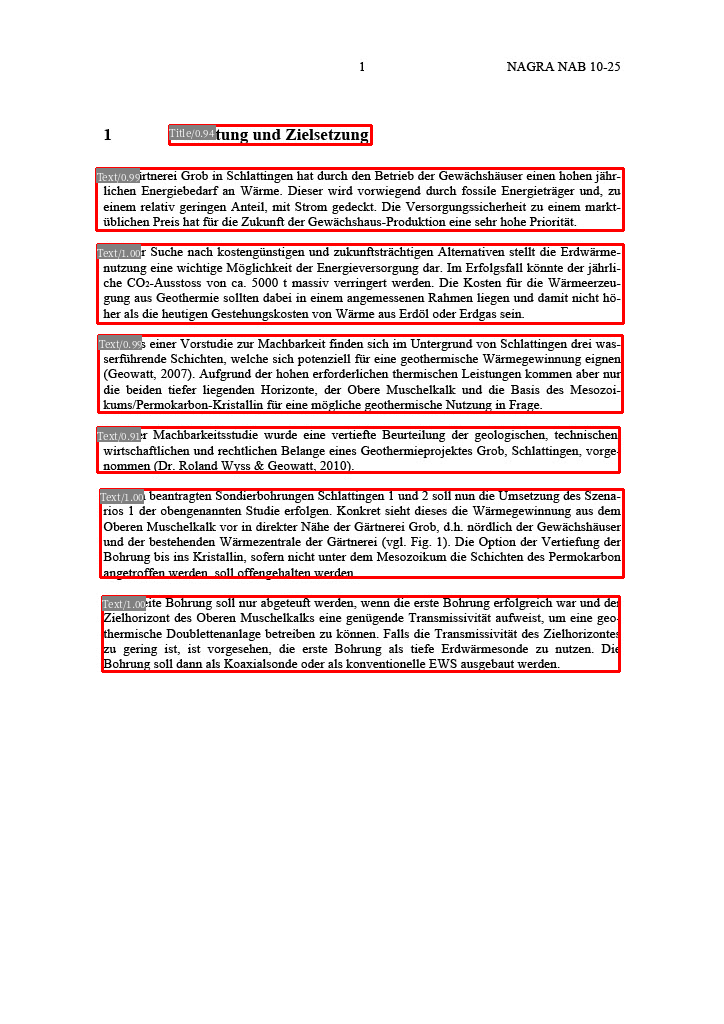

In [28]:
lp.draw_box(image, 
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=color_map,
              show_element_id=True, id_font_size=10, 
              id_text_background_color='grey',
              id_text_color='white')

In [29]:
layout[0]

TextBlock(block=Rectangle(x_1=102.22386932373047, y_1=596.0333862304688, x_2=619.8973388671875, y_2=671.2953491210938), text=None, id=None, type=Text, parent=None, next=None, score=0.995997428894043)

In [30]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [31]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [32]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
# The b.coordinates[1] corresponds to the y coordinate of the region
# sort based on that can simulate the top-to-bottom reading order 
right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

# And finally combine the two lists and add the index
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

In [33]:
ocr_agent = lp.TesseractAgent(languages='eng') 

In [35]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [36]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Die Gartnerei Grob in Schlattingen hat durch den Betrieb der Gewachshiuser einen hohen jahr-
lichen Energiebedarf an Warme. Dieser wird vorwiegend durch fossile Energietrager und, zu
einem relativ geringen Anteil, mit Strom gedeckt. Die Versorgungssicherheit zu einem markt-
‘ublichen Preis hat fir die Zukunft der Gewachshaus-Produktion eine sehr hohe Prioritat.

---
Auf der Suche nach kostengiinstigen und zukunfistrachtigen Altemativen stellt die Erdwarme-
sautzung eine wichtige Méglichkeit der Energieversorgung dar. Im Erfolgsfall kénnte der jahli-
che COz-Ausstoss von ca. 5000 t massiv verringert werden. Die Kosten fiir die Warmeerzen-
gung aus Geothermie sollten dabei in einem angemessenen Rahmen liegen und damit nicht
her als die heutigen Gestehungskosten von Warme aus Erdél oder Erdgas sein.

 

---
Gemiiss einer Vorstudie zur Machbarkeit finden sich im Untergrund von Schlattingen drei was-
serfiihrende Schichten, welche sich potenziell fr eine geothermische Warmegewinnung eigne